# Data Science Bowl 2018
https://www.kaggle.com/c/data-science-bowl-2018/data

In [1]:
import os
import sys
import random
import warnings
import tensorflow.keras

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K


from keras.utils import plot_model

import math

import tensorflow as tf

# set some parameters
img_width = 128
img_height = 128
img_channels = 3


!mkdir stage1_train stage1_test

# Data Path
train_path = './stage1_train/'
test_path = './stage1_test/'
print(train_path)
print(test_path)

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed


C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

./stage1_train/
./stage1_test/


In [2]:
import zipfile
with zipfile.ZipFile('./dataset/stage1_train.zip') as zf:
    zf.extractall('./stage1_train')
    print('uncompress success')
    
    zf.close()

uncompress success


In [3]:
with zipfile.ZipFile('./dataset/stage1_test.zip') as zf:
    zf.extractall('./stage1_test')
    print('uncompress success')
    
    zf.close()

uncompress success


In [4]:
print(os.listdir('dataset'))

['stage1_sample_submission.csv.zip', 'stage1_solution.csv.zip', 'stage1_test.zip', 'stage1_train.zip', 'stage1_train_labels.csv.zip', 'stage2_sample_submission_final.csv.zip', 'stage2_test_final.zip']


In [5]:
train_ids = next(os.walk(train_path))[1]
test_ids = next(os.walk(test_path))[1]

## Load the Data

In [6]:
# resize train images and masks
x_train = np.zeros((len(train_ids), img_height, img_width, img_channels), dtype=np.uint8)
y_train = np.zeros((len(train_ids), img_height, img_width, 1), dtype=np.bool)

print('Getting and resizing train images and masks >>>')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    # img file path that contains img and mask
    path = train_path + id_
    
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]    
    # resize -> (128, 128, 3)
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    x_train[n] = img
    mask = np.zeros((img_height, img_width, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        # expand_dims -> (128, 128, 1)
        mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant',
                                     preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    y_train[n] = mask
    
    
# resize test images and masks
x_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.uint8)
sizes_test = []
print('etting and resizeing test images >>>')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = test_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:img_channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    print('test_img', img.shape)
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    print('test_img', img.shape)
    x_test[n] = img
    
print('Done')


# sys.stdout.flush()
# mask = np.maximum(mask, mask_)
# np.bool
# tqdm

Getting and resizing train images and masks >>>


100%|███████████████████████████████████████████| 670/670 [04:02<00:00,  2.76it/s]

etting and resizeing test images >>>



  9%|████▏                                         | 6/65 [00:00<00:01, 57.30it/s]

test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (519, 253, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (512, 680, 3)
test_img (128, 128, 3)
test_img (512, 640, 3)
test_img (128, 128, 3)
test_img (512, 680, 3)
test_img (128, 128, 3)
test_img (512, 640, 3)


 23%|██████████▍                                  | 15/65 [00:00<00:01, 43.41it/s]

test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (519, 162, 3)
test_img (128, 128, 3)
test_img (512, 640, 3)
test_img (128, 128, 3)
test_img (524, 348, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (512, 680, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (519, 253, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (524, 348, 3)
test_img (128, 128, 3)


 34%|███████████████▏                             | 22/65 [00:00<00:00, 48.71it/s]

test_img (520, 348, 3)
test_img (128, 128, 3)
test_img (260, 347, 3)
test_img (128, 128, 3)
test_img (512, 680, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (512, 680, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (390, 239, 3)
test_img (128, 128, 3)


 42%|██████████████████▋                          | 27/65 [00:00<00:00, 48.99it/s]

test_img (512, 640, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (260, 347, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)


 52%|███████████████████████▌                     | 34/65 [00:00<00:00, 52.89it/s]

test_img (520, 348, 3)
test_img (128, 128, 3)
test_img (512, 640, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (260, 347, 3)
test_img (128, 128, 3)
test_img (520, 348, 3)
test_img (128, 128, 3)
test_img (512, 640, 3)
test_img (128, 128, 3)


 63%|████████████████████████████▍                | 41/65 [00:00<00:00, 53.10it/s]

test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (512, 640, 3)
test_img (128, 128, 3)
test_img

 72%|████████████████████████████████▌            | 47/65 [00:00<00:00, 49.11it/s]

 (520, 696, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (512, 640, 3)
test_img (128, 128, 3)
test_img (512, 680, 3)
test_img (128, 128, 3)
test_img (519, 253, 3)
test_img (128, 128, 3)
test_img (519, 161, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (520, 696, 3)
test_img (128, 128, 3)
test_img (524, 348, 3)


 80%|████████████████████████████████████         | 52/65 [00:01<00:00, 46.91it/s]

test_img (128, 128, 3)
test_img (520, 696, 3)
test_img (128, 128, 3)
test_img (524, 348, 3)
test_img (128, 128, 3)
test_img (519, 161, 3)
test_img (128, 128, 3)
test_img (519, 162, 3)
test_img (128, 128, 3)
test_img (520, 348, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (512, 680, 3)
test_img (128, 128, 3)


 91%|████████████████████████████████████████▊    | 59/65 [00:01<00:00, 51.64it/s]

test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (260, 347, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (519, 253, 3)
test_img (128, 128, 3)


100%|█████████████████████████████████████████████| 65/65 [00:01<00:00, 51.32it/s]

test_img (520, 696, 3)
test_img (128, 128, 3)
test_img (512, 680, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
test_img (256, 256, 3)
test_img (128, 128, 3)
Done


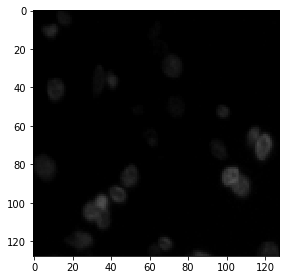

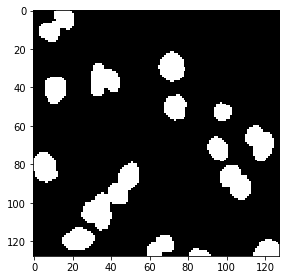

In [7]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()

## Mean IOU

In [8]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    print(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0,1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union,0), 1., tf.cast(inter/union, 'float32'))
    return iou


## Build and train U-Net

In [9]:
# Build U-Net model
def unet(sz = (128, 128, 3)):
    inputs = Input((img_height, img_width, img_channels))
    s = Lambda(lambda x:x / 255) (inputs)
    
    in_channels = 16
    
    # DOWNSAMPLING
    # (128, 128, 16)
    x1 = Conv2D(in_channels, 3, activation='relu', kernel_initializer='he_normal', padding='same')(s)
    x1 = BatchNormalization()(x1)
    x1 = Conv2D(in_channels, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x1)
    x1 = BatchNormalization()(x1)
    p1 = MaxPooling2D((2,2))(x1) # (64, 64, 16)
    
    # (64, 64, 32)
    x2 = Conv2D(in_channels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    x2 = BatchNormalization()(x2)
    x2 = Conv2D(in_channels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x2)
    x2 = BatchNormalization()(x2)
    p2 = MaxPooling2D((2,2))(x2) # (32, 32, 32)
    
    # (32, 32, 64)
    x3 = Conv2D(in_channels*4, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    x3 = BatchNormalization()(x3)
    x3 = Conv2D(in_channels*4, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x3)
    x3 = BatchNormalization()(x3)
    p3 = MaxPooling2D((2,2))(x3) # (16, 16, 64)
    
    # (16, 16, 128)
    x4 = Conv2D(in_channels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    x4 = BatchNormalization()(x4)
    x4 = Conv2D(in_channels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x4)
    x4 = BatchNormalization()(x4)
    p4 = MaxPooling2D((2,2))(x4) # (8, 8, 128)
    

    # (8, 8, 256)
    bottleneck = Conv2D(in_channels*16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    bottleneck = Dropout(0.3)(bottleneck)
    bottleneck = Conv2D(in_channels*16, 3, activation='relu', kernel_initializer='he_normal', padding='same')(bottleneck)
    
    # UPSAMPLING
    # (16, 16, 128)
    u6 = Conv2DTranspose(in_channels*8, 2, strides=(2,2), padding='same')(bottleneck)
    u6 = concatenate([u6, x4]) # (16, 16,  256)
    x6 = Conv2D(in_channels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    x6 = BatchNormalization()(x6) 
    x6 = Conv2D(in_channels*8, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x6)
    
    # (32, 32, 64)
    u7 = Conv2DTranspose(in_channels*4, 2, strides=(2,2), padding='same')(x6)
    u7 = concatenate([u7, x3]) # (32, 32, 128)
    x7 = Conv2D(in_channels*4, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    x7 = BatchNormalization()(x7)
    x7 = Conv2D(in_channels*4, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x7)
    
    # (64, 64, 32)
    u8 = Conv2DTranspose(in_channels*2, 2, strides=(2,2), padding='same')(x7)
    u8 = concatenate([u8, x2]) # (64, 64, 64)
    x8 = Conv2D(in_channels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    x8 = BatchNormalization()(x8)
    x8 = Conv2D(in_channels*2, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x8)
    
    # (128, 128, 16)
    u9 = Conv2DTranspose(in_channels, 2, strides=(2,2), padding='same')(x8)
    u9 = concatenate([u9, x1]) # (128, 128, 32)
    x9 = Conv2D(in_channels, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    x9 = BatchNormalization()(x9)
    x9 = Conv2D(in_channels, 3, activation='relu', kernel_initializer='he_normal', padding='same')(x9)
     
    # classification
    # (128, 128, 1)
    outputs = Conv2D(1, (1,1), activation='sigmoid')(x9)
    
    # model creation
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    return model

In [10]:
model = unet()


Tensor("metrics/mean_iou/LogicalAnd:0", shape=(?, 128, 128), dtype=bool)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


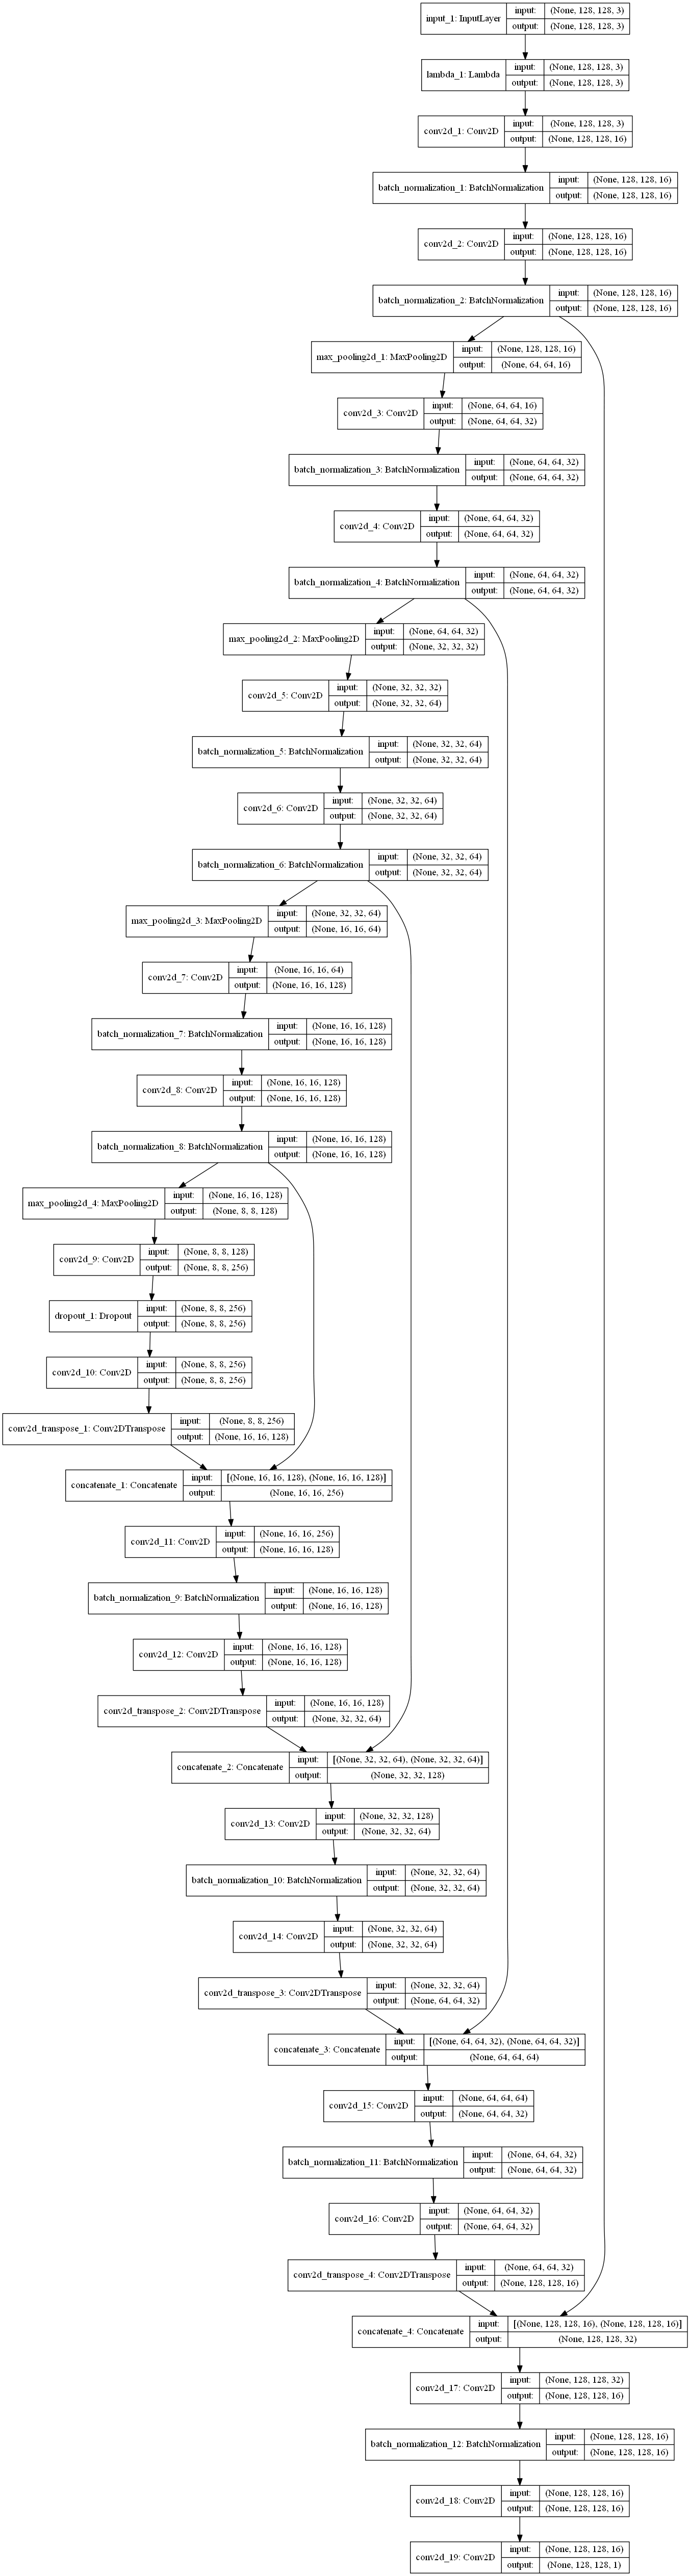

In [11]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [17]:
# fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl.h5', verbose=1, save_best_only=True)
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=50,
                   callbacks=[earlystopper, checkpointer])


Train on 603 samples, validate on 67 samples
Epoch 1/50
603/603 [==============================] - 2s 3ms/step - loss: 0.0419 - mean_iou: 0.9178 - val_loss: 0.0807 - val_mean_iou: 0.8715

Epoch 00001: val_loss improved from inf to 0.08071, saving model to model-dsbowl.h5
Epoch 2/50
603/603 [==============================] - 2s 3ms/step - loss: 0.0422 - mean_iou: 0.9166 - val_loss: 0.0951 - val_mean_iou: 0.8651

Epoch 00002: val_loss did not improve from 0.08071
Epoch 3/50
603/603 [==============================] - 2s 3ms/step - loss: 0.0428 - mean_iou: 0.9151 - val_loss: 0.0826 - val_mean_iou: 0.8665

Epoch 00003: val_loss did not improve from 0.08071
Epoch 4/50
603/603 [==============================] - 2s 3ms/step - loss: 0.0420 - mean_iou: 0.9165 - val_loss: 0.0854 - val_mean_iou: 0.8703

Epoch 00004: val_loss did not improve from 0.08071
Epoch 5/50
603/603 [==============================] - 2s 3ms/step - loss: 0.0437 - mean_iou: 0.9142 - val_loss: 0.0836 - val_mean_iou: 0.8680

Epo

## Make predictions

In [20]:
# Predict on train, val and test
model = load_model('model-dsbowl.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(x_train[:int(x_train.shape[0]+0.9)], verbose=1)
preds_val = model.predict(x_train[int(x_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(x_test, verbose=1)

# Threshold prediction
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test >= 0.5).astype(np.uint8)

# Create list of upsampling test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i][1]),
                                      (sizes_test[i][0], sizes_test[i][1]),
                                      mode='constant', preserve_range=True))

Tensor("metrics_3/mean_iou/LogicalAnd:0", shape=(?, 128, 128), dtype=bool)
65/65 [==============================] - 0s 1ms/step


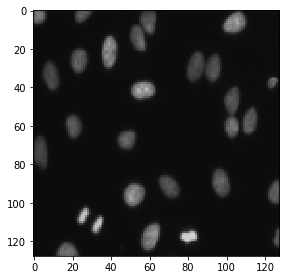

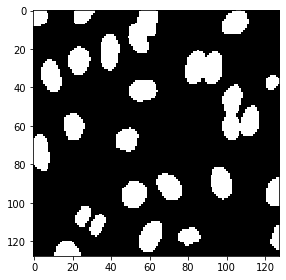

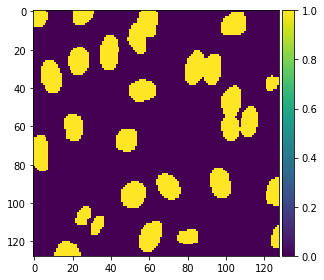

In [82]:
# Visualize
ix = random.randint(0, len(preds_val_t))
imshow(x_train[int(x_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()